In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
opt = {
    "envs": ["lunar_lander", "half_cheetah"],
    "dreamer_files": {
        "lunar_lander": ["/data/petabyte/dreamer_vfd/dreamer_vfd/mo-lunar-lander-continuous-v2/ds_32_ss_32_bs_16_sl_64_te_4/eval_data.pkl"],
        "half_cheetah": ["/data/petabyte/dreamer_vfd/dreamer_vfd/mo-halfcheetah-v4_old/ds_32_ss_32/eval_data.pkl"],
    },
    "tdmpc2_files": {
        "half_cheetah": [
            "/opt/home/tdmpc2/half_cheetah/1/default/eval.csv",
            "/opt/home/tdmpc2/half_cheetah/2/default/eval.csv",
            "/opt/home/tdmpc2/half_cheetah/3/default/eval.csv",
            "/opt/home/tdmpc2/half_cheetah/4/default/eval.csv",
        ],
        "lunar_lander": [
            "/opt/home/tdmpc2/lunar_lander/1/default/eval.csv",
            "/opt/home/tdmpc2/lunar_lander/2/default/eval.csv",
            "/opt/home/tdmpc2/lunar_lander/3/default/eval.csv",
            "/opt/home/tdmpc2/lunar_lander/4/default/eval.csv",
        ],
    },
    "reward_cols": {
        "dreamer": "scalar reward",
        "tdmpc2": "episode_reward"
    }
}

In [3]:
def read_tdmpc2_dfs(csv_files: list) -> pd.DataFrame:
    dfs = []
    for csv_file in csv_files:
        csv_file = Path(csv_file)
        seed = csv_file.parent.parent.name
        df = pd.read_csv(csv_file)
        df.insert(len(df.columns), "Seed", [seed]*len(df.index))
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [4]:
# read in data
dreamer_dfs = {
    k: pd.concat([pd.read_pickle(v) for v in values], ignore_index=True) for k, values in opt["dreamer_files"].items()
}
tdmpc2_dfs = {
    k: read_tdmpc2_dfs(v) for k, v in opt["tdmpc2_files"].items()
}

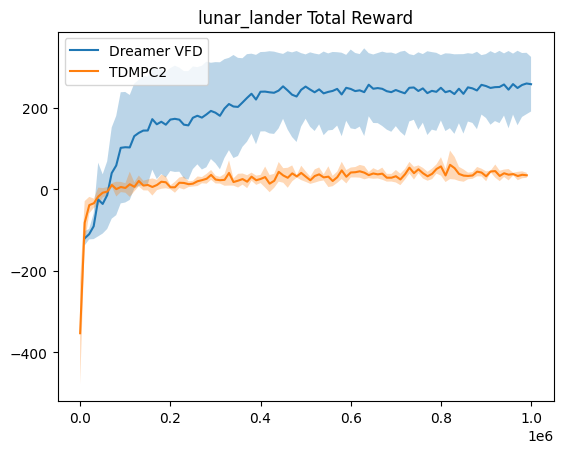

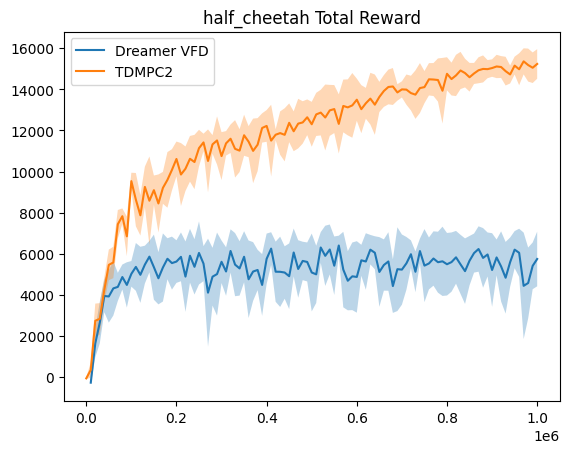

In [10]:
for env in opt["envs"]:
    ddfs = dreamer_dfs[env]
    tdfds = tdmpc2_dfs[env]
    gb = ddfs.groupby(["Checkpoint"])
    dreamer_data = gb[opt["reward_cols"]["dreamer"]].mean().to_numpy()
    dreamer_error = gb[opt["reward_cols"]["dreamer"]].std().to_numpy()
    dreamer_x = list(gb.indices.keys())
    plt.plot(dreamer_x, dreamer_data, label="Dreamer VFD")
    plt.fill_between(dreamer_x, dreamer_data - dreamer_error, dreamer_data + dreamer_error, alpha=0.3)
    tdmpc2_seeds = tdfds["Seed"].unique()
    tdmpc2_data = np.empty((len(tdmpc2_seeds), int(len(tdfds.index) / len(tdmpc2_seeds))))
    tdmpc2_x = np.empty((len(tdmpc2_seeds), int(len(tdfds.index) / len(tdmpc2_seeds))))
    for i, seed in enumerate(tdmpc2_seeds):
        seed_df = tdfds[tdfds["Seed"] == seed]
        tdmpc2_data[i] = seed_df[opt["reward_cols"]["tdmpc2"]].to_numpy()
        tdmpc2_x[i] = seed_df["step"]
    tdmpc2_mean = np.mean(tdmpc2_data, axis=0)
    tdmpc2_std = np.std(tdmpc2_data, axis=0)
    tdmpc2_x = np.mean(tdmpc2_x, axis=0)
    plt.plot(tdmpc2_x, tdmpc2_mean, label="TDMPC2")
    plt.fill_between(tdmpc2_x, tdmpc2_mean - tdmpc2_std, tdmpc2_mean + tdmpc2_std, alpha=0.3)
    plt.legend()
    plt.title(f"{env} Total Reward")
    plt.show()